# MovieLens recommender system
## Creating our dataset

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/data/train_test_movielens1m.ipynb)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import zipfile
import os, shutil

## Download data
The first step is to download the data from the MovieLens website. The permalink for this dataset is [https://grouplens.org/datasets/movielens/1m/](https://grouplens.org/datasets/movielens/1m/)

The code below will perform the task of downloading the zipped file and extracting all of its contents into a new folder in your current directory.   
We will make use of a few handy Python libraries, namely:
  - **`urllib`** for downloading the data from the web
  - **`zipfile`** for extracting the data
  - **`os`** and **`shutil`** for navigating our local file directories.

Run the block below and look out for the new folder `ml-1m`. 

In [2]:
# in case you already have a folder named ml-1m
try:
    shutil.rmtree('./ml-1m')
    print('ml-1m directory already exists, removing it first')
except:
    print('no existing directory found, all good')

# stable link for dataset
url = 'http://files.grouplens.org/datasets/movielens/'
filename = 'ml-1m.zip'

# download zip file from link
print('downloading and saving dataset from movielens stable link...')
downloaded = urlopen(url + filename)
buf = downloaded.read()

# save file and extract contents
with open(filename, 'wb') as f:
    f.write(buf)

print('unzipping contents')
with zipfile.ZipFile(filename) as zip:
    zip.extractall('.')
    
# add .txt to readme file
os.rename('./ml-1m/README', './ml-1m/README.txt')

# remove zip file from directory
print('deleting zip file')
os.remove('ml-1m.zip')

ml-1m directory already exists, removing it first
downloading and saving dataset from movielens stable link...
unzipping contents
deleting zip file


## Process data files

Open up the folder that's been downloaded to your computer and explore its contents. You might find it handy to open up the file named `README.txt`, which contains some additional information about this dataset.

In addition to the readme, you should also see `movies.dat`, `ratings.dat` and `users.dat`. We are going to open these files up and do a little pre-processing on them so that they will be easier to use in our collaborative filtering model later.

In [3]:
path = 'ml-1m/'

In [4]:
df = pd.read_csv(path+'ratings.dat',
                 sep='::',
                 names=['userId', 'movieId', 'rating', 'timestamp'],
                 engine='python').drop('timestamp', axis=1)

In [5]:
df.head()

,userId,movieId,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [6]:
df.shape

(1000209, 3)

In [8]:
(df.rating.min(), df.rating.max())

(1, 5)

The ratings dataset contains all ratings of movies made by users. These ratings are known as interactions.
In total, there are 1 000 209 interactions between users and movies, ranging between 1 and 5.

The movies and users datasets contain some metadata for each of the movie and user IDs in the ratings data.
Each movie has a title and one or more genres associated with it, while each user has metadata for gender, age, occupation and zip code. Perhaps these additional data will be useful in a content-based recommender system?

In [9]:
movies = pd.read_csv(path+'movies.dat',
                     sep='::',
                     names=['movieId', 'title', 'genres'],
                     engine='python')

users = pd.read_csv(path+'users.dat',
                    sep='::',
                    names=['userId', 'gender', 'age', 'occupation', 'zipCode'],
                    engine='python')

In [10]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
movies.shape

(3883, 3)

In [12]:
users.head()

,userId,gender,age,occupation,zipCode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [13]:
users.shape

(6040, 5)

We have metadata for 3883 movies and 6040 users, but we only need to keep the information for movies that have been rated and for users that have rated at least one movie.   
Let's use the list of unique user and movie ids from the ratings data to filter through the metadata entries.

In [14]:
user_ids = df['userId'].unique()
movie_ids = df['movieId'].unique()

In [15]:
# length before
print(len(movies), len(users))

# keep metadata only for movies that have receieved ratings
movies = movies[movies['movieId'].isin(movie_ids)]
users = users[users['userId'].isin(user_ids)]

# length after
print(len(movies), len(users))

3883 6040
3706 6040


We can see that only 3706 movies from the movies dataset appear in the ratings data, so we will only keep these.

### Encode IDs from 0-n
The next step is to ensure that all user IDs are sequential between 0 and n (the number of users). This will be necessary when we use these IDs in an embedding layer of a tensorflow model.

We can do this using dictionaries. We will create an encoder to map from the original IDs to the sequential IDs.

In [16]:
def create_encoder(data, start=0):

    encoder = {}

    idx = start
    for item in data:

        if item not in encoder.keys():
            encoder[item] = idx
            idx += 1

    return encoder

In [19]:
# create ID encoders
user_encoder = create_encoder(user_ids)
movie_encoder = create_encoder(movie_ids)

In [20]:
# replace all IDs with sequential 0-N IDs
df['userId'] = df['userId'].apply(lambda x: user_encoder[x])
df['movieId'] = df['movieId'].apply(lambda x: movie_encoder[x])

users['userId'] = users['userId'].apply(lambda x: user_encoder[x])
movies['movieId'] = movies['movieId'].apply(lambda x: movie_encoder[x])

In [21]:
n_users = df.userId.nunique()
n_items = df.movieId.nunique()
max_score = df.rating.max()
min_score = df.rating.min()

In [22]:
print(n_users, df.userId.max())
print(n_items, df.movieId.max())
print(min_score, max_score)

6040 6039
3706 3705
1 5


### Train / test split

In [23]:
train, test, _, _ = train_test_split(df, df.rating,
                                     test_size = .2,
                                     random_state=42,
                                     stratify=df.userId)

In [24]:
train.shape

(800167, 3)

In [25]:
test.shape

(200042, 3)

In [26]:
train.to_csv(path+'train.csv', index=False)
test.to_csv(path+'test.csv', index=False)

In [27]:
movies.to_csv(path+'movies.csv', index=False)
users.to_csv(path+'users.csv', index=False)

### remove all other files

In [28]:
dir_name = "./ml-1m/"
folder = os.listdir(dir_name)

for item in folder:
    if not (item.endswith(".csv") or item.endswith(".txt")):
        os.remove(os.path.join(dir_name, item))

## EDA

In [29]:
from glob import glob

In [36]:
ratings = glob(path+'t*.csv')

In [37]:
# load all of train and test data as one dataframe
df = pd.concat((pd.read_csv(file) for file in ratings), ignore_index=True)
movies = pd.read_csv(path+'movies.csv')
users = pd.read_csv(path+'users.csv')

# create one merged DataFrame
df = pd.merge(movies, df)[['userId','movieId','rating','title']]
df = pd.merge(df, users)

In [38]:
df.shape

(1000209, 8)

In [49]:
df.head()

,userId,movieId,rating,title,gender,age,occupation,zipCode
0,3370,40,5,Toy Story (1995),M,25,2,55405
1,3370,1256,4,"American President, The (1995)",M,25,2,55405
2,3370,504,5,Leaving Las Vegas (1995),M,25,2,55405
3,3370,376,2,Twelve Monkeys (1995),M,25,2,55405
4,3370,221,4,Clueless (1995),M,25,2,55405


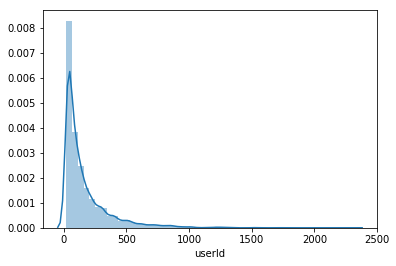

Max ratings by single user: 2314
Min ratings by single user: 20
Avg number of ratings per user: 166


In [39]:
user_counts = df['userId'].value_counts()

sns.distplot(user_counts)
plt.show()

# user with most ratings
print('Max ratings by single user:',
      user_counts.max())

# user with fewest ratings
print('Min ratings by single user:',
      user_counts.min())

# average number of ratings per user
print('Avg number of ratings per user:',
      round(user_counts.mean()))

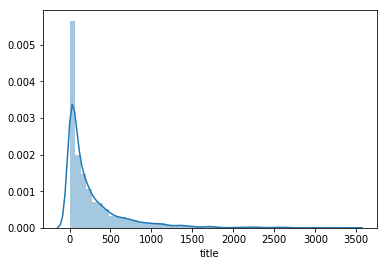

Max ratings of single movie: 3428
Min ratings of single movie: 1
Avg number of ratings per movie: 270


In [40]:
movie_counts = df['title'].value_counts()

sns.distplot(movie_counts)
plt.show()

# movie with most ratings
print('Max ratings of single movie:',
      movie_counts.max())

# movie with fewest ratings
print('Min ratings of single movie:',
      movie_counts.min())

# average number of ratings per book
print('Avg number of ratings per movie:',
      round(movie_counts.mean()))

In [47]:
movie_counts.head()

American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Name: title, dtype: int64

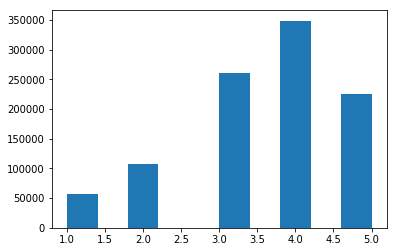

Avg rating: 3.58


In [48]:
plt.hist(df['rating'].values)
plt.show()

print('Avg rating:', round(df['rating'].mean(),2))